<a href="https://colab.research.google.com/github/melody-gold/csci303_project/blob/main/CSCI303_Semester_Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Filter warnings
import warnings
warnings.filterwarnings("ignore", category=Warning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import libraries
import folium
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns

from scipy.stats import mode
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
# Function to read data from host location on GitHub
def load_csv_from_url(url):
    response = requests.get(url)
    response.raise_for_status()
    return pd.read_csv(io.StringIO(response.text))

# Read the data and add some error handling for file not found
df = load_csv_from_url("https://raw.githubusercontent.com/Dr-Queue/CSCI303_DATA/refs/heads/main/SCHOOL_DATA.csv")

# Keep only high school data
df = df[df['school_level'] == 'High']

# Keep only some columns
df = df[['enrollment', 'school_name', 'city_location', 'latitude', 'longitude', 'urban_centric_locale',
        'sch_internet_wifi', 'students_SAT_ACT', 'enrl_biology', 'students_susp_in_sch', 'students_susp_out_sch_single', 'students_susp_out_sch_multiple', 'days_suspended',
        'suspensions_instances', 'teachers_fte_crdc', 'teachers_certified_fte', 'teachers_absent_fte', 'instructional_aides_fte', 'counselors_fte',
        'support_fte', 'social_workers_fte', 'administration_fte', 'psychologists_fte', 'nurses_fte', 'law_enforcement_fte', 'security_guard_fte',
        'salaries_teachers', 'salaries_total', 'salaries_instruc_staff', 'salaries_instructional_aides', 'salaries_support', 'salaries_administration',
        'expenditures_nonpersonnel',  'title_i_eligible']]

# Read in the graduation rate data
df_grad = load_csv_from_url("https://raw.githubusercontent.com/Dr-Queue/CSCI303_DATA/refs/heads/main/GRAD_DATA.csv")

# Merge the datasets based on school name
df = df.merge(df_grad[['School Name', '2021 grad rate']],
              left_on='school_name',
              right_on='School Name',
              how='left')

# Drop rows that don't have graduation data or where grad data is '-'
df = df.dropna(subset=['2021 grad rate'])
df = df[df['2021 grad rate'] != '-']

# Rename column to grad_rate and drop the school names
df = df.rename(columns={'2021 grad rate': 'grad_rate'}).drop(columns=['School Name', 'school_name'])

print(df.shape)
df.info()

(378, 34)
<class 'pandas.core.frame.DataFrame'>
Index: 378 entries, 0 to 446
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   enrollment                      378 non-null    object 
 1   city_location                   378 non-null    object 
 2   latitude                        378 non-null    float64
 3   longitude                       378 non-null    float64
 4   urban_centric_locale            378 non-null    object 
 5   sch_internet_wifi               373 non-null    object 
 6   students_SAT_ACT                373 non-null    float64
 7   enrl_biology                    341 non-null    float64
 8   students_susp_in_sch            361 non-null    object 
 9   students_susp_out_sch_single    361 non-null    object 
 10  students_susp_out_sch_multiple  361 non-null    object 
 11  days_suspended                  361 non-null    float64
 12  suspensions_instances          

In [ ]:
# Data cleaning

# Drop rows with multiple missing values (more than 3)
df_cleaned = df.dropna(thresh=len(df.columns) - 3)

# Remap "Yes" and "No" to 1 and 0
df_cleaned['title_i_eligible'] = df_cleaned['title_i_eligible'].map({'Yes': 1, 'No': 0})
df_cleaned['sch_internet_wifi'] = df_cleaned['sch_internet_wifi'].map({'Yes': 1, 'No': 0})

# Encode urban_centric_locale using one hot encoding
# Grouping into city, suburb, town, and rural to prevent adding lots of new columns
group_mapping = {
    'City, large': 'City',
    'City, midsize': 'City',
    'City, small': 'City',
    'Suburb, large': 'Suburb',
    'Suburb, midsize': 'Suburb',
    'Suburb, small': 'Suburb',
    'Town, remote': 'Town',
    'Town, distant': 'Town',
    'Town, fringe': 'Town',
    'Rural, fringe': 'Rural',
    'Rural, remote': 'Rural',
    'Rural, distant': 'Rural'
}
df_cleaned['locale_group'] = df_cleaned['urban_centric_locale'].map(group_mapping)
df_cleaned = pd.get_dummies(df_cleaned, columns=['locale_group'], prefix='locale')
df_cleaned = df_cleaned.drop(columns=['urban_centric_locale'])

# Convert numeric data stored as strings to floats
df_cleaned[['enrollment', 'salaries_teachers', 'salaries_instruc_staff', 'students_susp_in_sch', 'students_susp_out_sch_single', 'students_susp_out_sch_multiple', 'grad_rate']] = df_cleaned[['enrollment', 'salaries_teachers', 'salaries_instruc_staff', 'students_susp_in_sch', 'students_susp_out_sch_single', 'students_susp_out_sch_multiple','grad_rate']].apply(pd.to_numeric, errors='coerce')

# Fill missing values with median - can refine this later, other fill methods may make more sense
num_cols = df_cleaned.columns.difference(['city_location', 'latitude', 'longitude'])
df_cleaned[num_cols] = df_cleaned[num_cols].fillna(df_cleaned[num_cols].median())
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 361 entries, 1 to 446
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   enrollment                      361 non-null    int64  
 1   city_location                   361 non-null    object 
 2   latitude                        361 non-null    float64
 3   longitude                       361 non-null    float64
 4   sch_internet_wifi               361 non-null    float64
 5   students_SAT_ACT                361 non-null    float64
 6   enrl_biology                    361 non-null    float64
 7   students_susp_in_sch            361 non-null    float64
 8   students_susp_out_sch_single    361 non-null    float64
 9   students_susp_out_sch_multiple  361 non-null    float64
 10  days_suspended                  361 non-null    float64
 11  suspensions_instances           361 non-null    float64
 12  teachers_fte_crdc               361 non-n

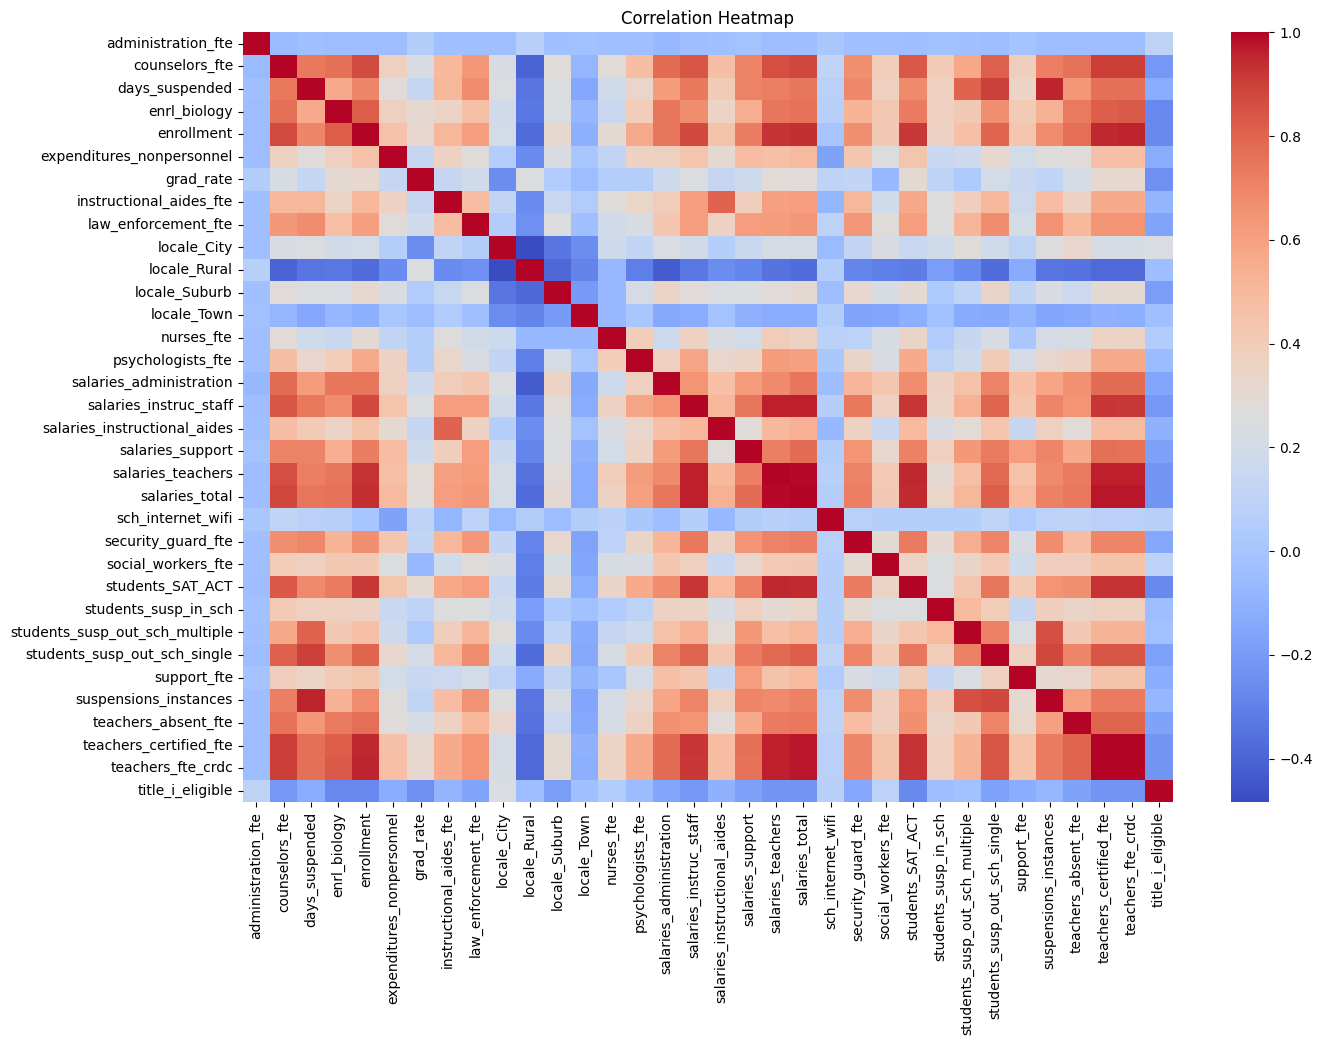

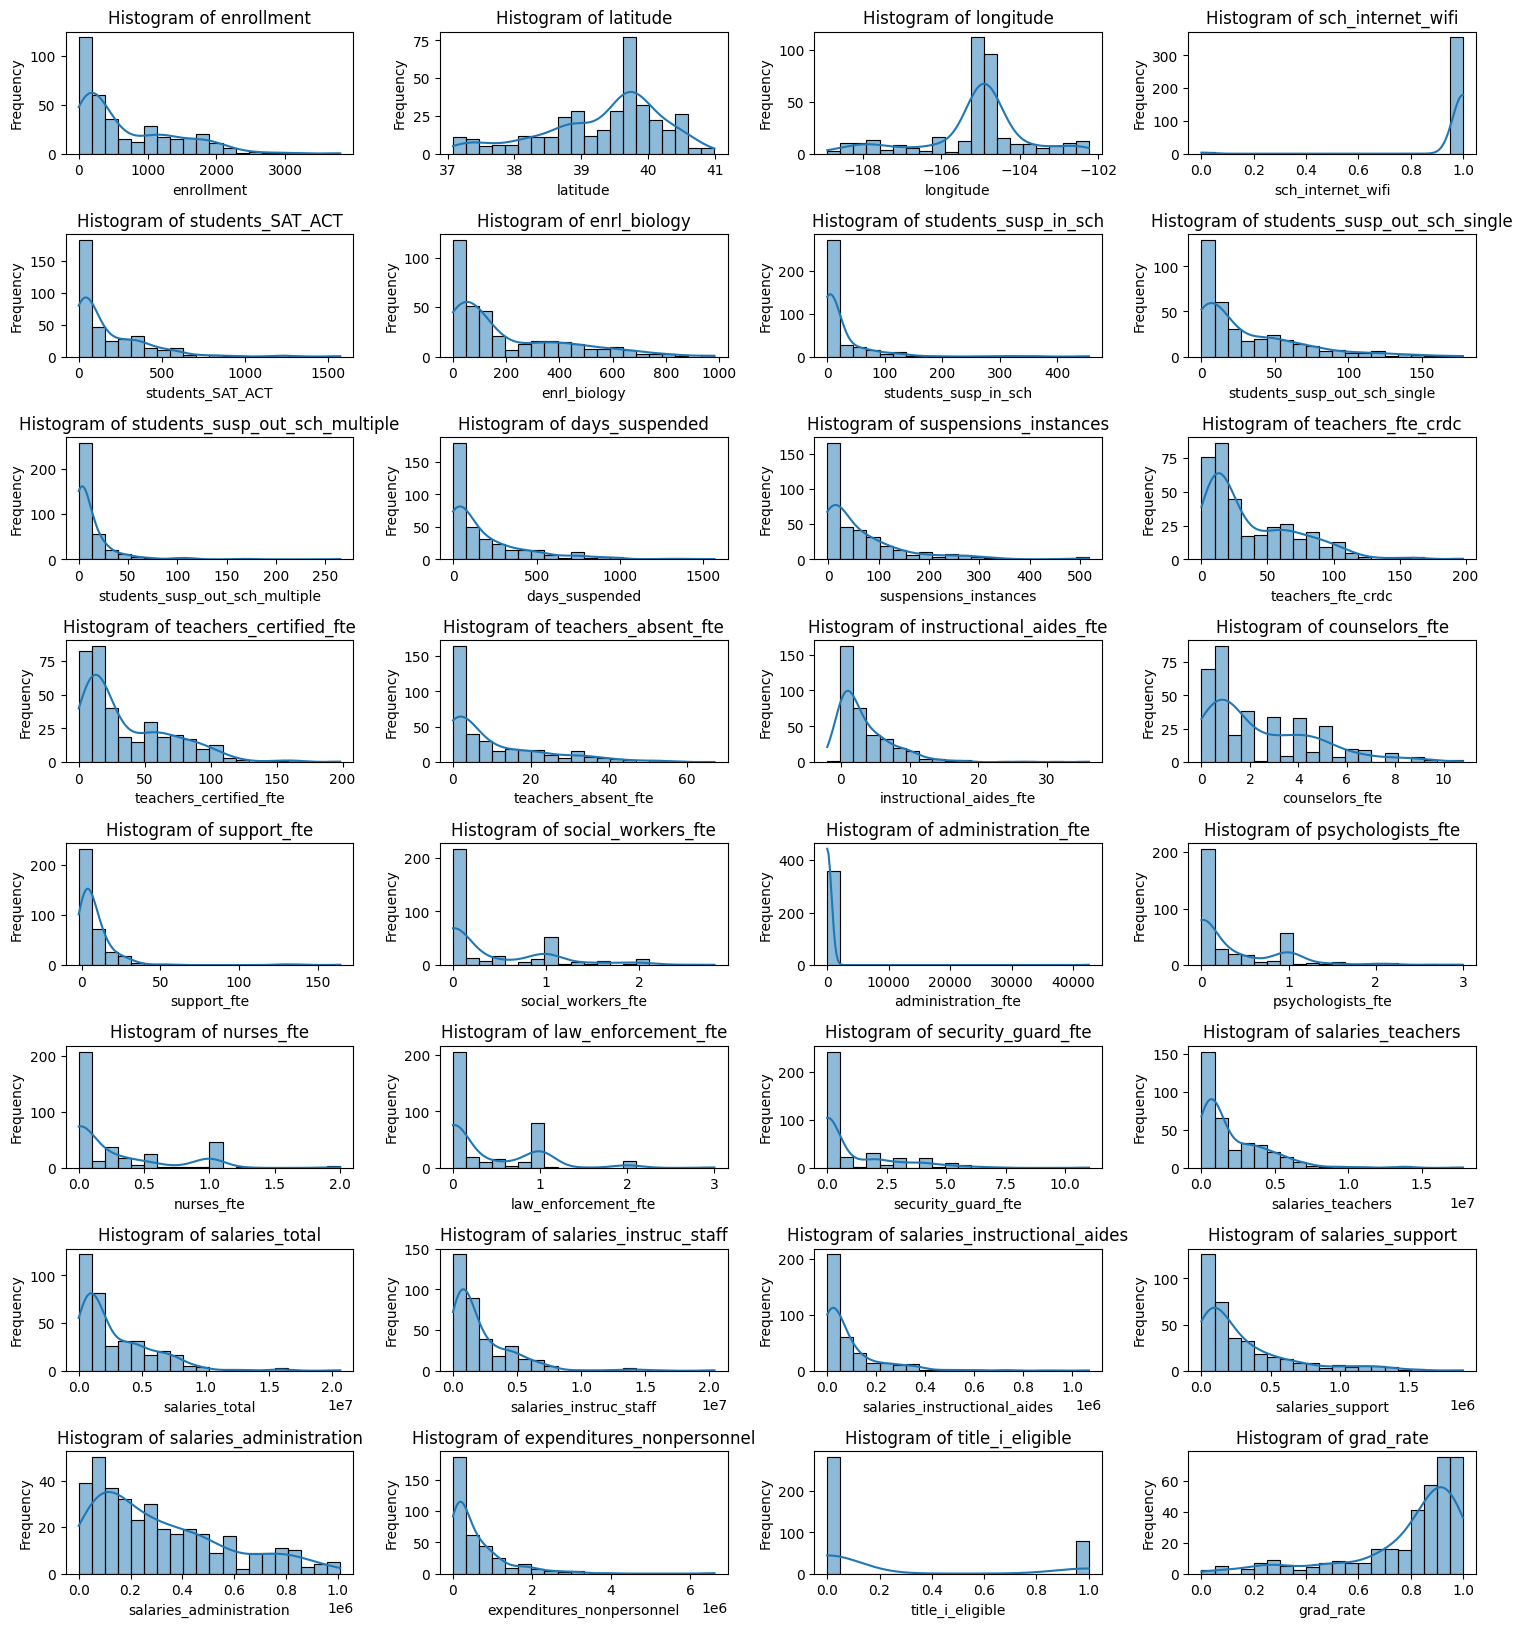

Dataset statistics:



,enrollment,latitude,longitude,sch_internet_wifi,students_SAT_ACT,enrl_biology,students_susp_in_sch,students_susp_out_sch_single,students_susp_out_sch_multiple,days_suspended,...,security_guard_fte,salaries_teachers,salaries_total,salaries_instruc_staff,salaries_instructional_aides,salaries_support,salaries_administration,expenditures_nonpersonnel,title_i_eligible,grad_rate
count,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,...,361.000000,3.610000e+02,3.610000e+02,3.610000e+02,3.610000e+02,3.610000e+02,3.610000e+02,3.610000e+02,361.000000,361.000000
mean,700.858726,39.324398,-105.146277,0.983380,177.196676,201.119114,25.217452,30.952909,13.429363,187.770083,...,0.968061,2.194859e+06,2.914967e+06,2.224947e+06,8.902647e+04,2.936160e+05,3.166085e+05,5.940978e+05,0.218837,0.791725
std,703.369943,0.889213,1.343514,0.128022,220.266386,218.454279,53.375014,35.663481,25.986131,256.061407,...,1.672235,2.446086e+06,2.960961e+06,2.575463e+06,1.365926e+05,3.449982e+05,2.553652e+05,7.394952e+05,0.414031,0.222961
min,0.000000,37.080075,-108.903406,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-2.000000,...,0.000000,4.450000e+03,-2.000000e+00,1.403500e+04,-2.000000e+00,-2.000000e+00,-2.000000e+00,-2.000000e+00,0.000000,0.000000
25%,132.000000,38.812010,-105.183947,1.000000,28.000000,35.000000,0.000000,4.000000,1.000000,16.000000,...,0.000000,5.013770e+05,7.364320e+05,5.183620e+05,9.049000e+03,5.906776e+04,1.053803e+05,1.220140e+05,0.000000,0.734400
50%,387.000000,39.624300,-104.962800,1.000000,77.000000,100.000000,5.500000,16.000000,4.000000,78.000000,...,0.000000,1.171892e+06,1.717632e+06,1.266092e+06,3.896000e+04,1.655301e+05,2.518635e+05,3.018480e+05,0.000000,0.878600
75%,1180.000000,39.879900,-104.713611,1.000000,283.000000,336.000000,22.000000,48.000000,15.000000,269.000000,...,2.000000,3.422650e+06,4.433559e+06,3.010161e+06,1.089916e+05,3.888888e+05,4.636382e+05,8.256390e+05,0.000000,0.938000
max,3797.000000,40.990800,-102.244019,1.000000,1575.000000,982.000000,455.000000,178.000000,265.000000,1566.000000,...,11.000000,1.781038e+07,2.062155e+07,2.040226e+07,1.068014e+06,1.892603e+06,1.009812e+06,6.618479e+06,1.000000,1.000000


In [ ]:
# Data visualization and exploration

# Plot correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(df_cleaned[num_cols].corr(), annot=False, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Plotting histograms of numerical values
plt.figure(figsize=(15, 20))
for i, col in enumerate(df_cleaned.select_dtypes(include='number')):
    plt.subplot(10, 4, i + 1)
    sns.histplot(df_cleaned[col], bins=20, kde=True)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

print("Dataset statistics:\n")
df_cleaned.describe()

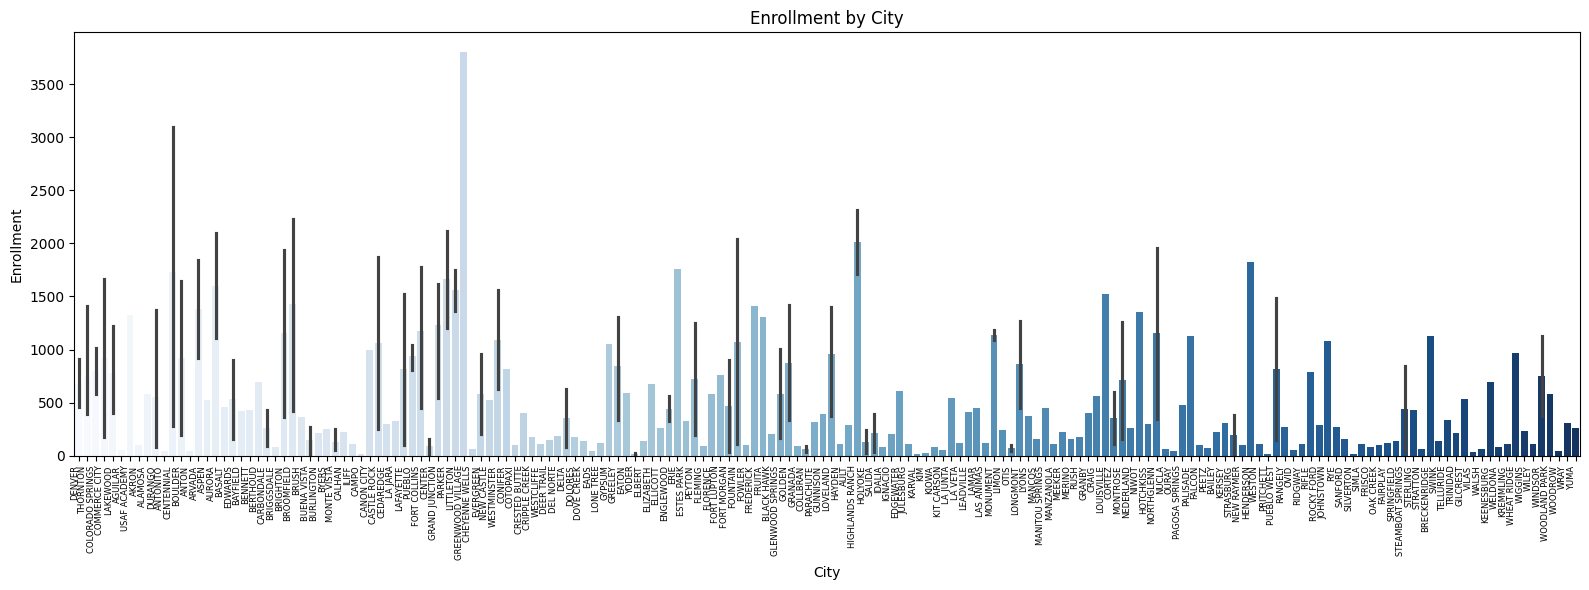

In [ ]:
# Create the bar chart
plt.figure(figsize=(16, 6))
sns.barplot(x='city_location', y='enrollment', data=df_cleaned, palette='Blues')
plt.title('Enrollment by City')
plt.xlabel('City')
plt.ylabel('Enrollment')
plt.xticks(rotation=90, ha='right', fontsize=6)
plt.tight_layout()
plt.show()

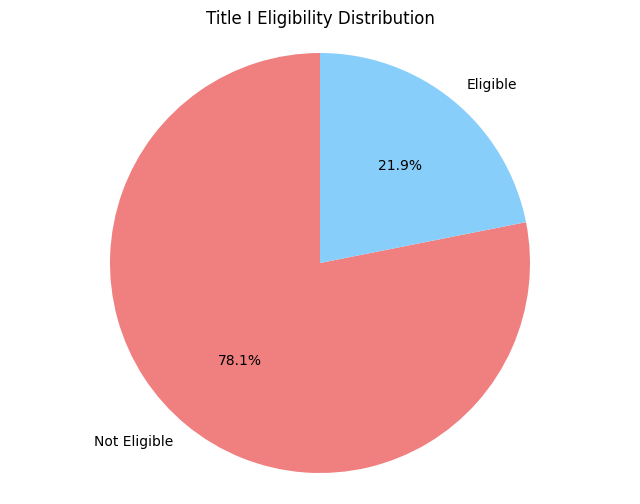

In [ ]:
# Create the pie chart
eligibility_counts = df_cleaned['title_i_eligible'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(eligibility_counts, labels=['Not Eligible', 'Eligible'], autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightskyblue'])
plt.title('Title I Eligibility Distribution')
plt.axis('equal')
plt.show()

In [ ]:
# Target data is grad_rate
y = df_cleaned['grad_rate']

# Remove target and plotting data from features
X = df_cleaned.drop(columns=['grad_rate', 'city_location', 'latitude', 'longitude'])

#Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


#Data splitting (train, test)
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)